## This notebook tests experimental features that will likely change.

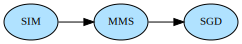

In [1]:
from lale.lib.rasl import SimpleImputer as SIM
from lale.lib.rasl import MinMaxScaler as MMS
from lale.lib.sklearn import SGDClassifier as SGD
from lale.lib.sklearn import RandomForestClassifier as RFC

def fresh_pipeline(final_est="sgd"):  #create new to guarantee fresh state after earlier fit/partial_fit, if any
    assert final_est in ["sgd", "rfc"]
    return (
        SIM(strategy="mean")
        >> MMS()
        >> (SGD(random_state=42) if final_est == "sgd" else RFC(random_state=42))
    )

fresh_pipeline().visualize()

In [2]:
from lale.lib.rasl import is_associative, is_incremental, PrioBatch, PrioStep, PrioResourceAware
from lale.lib.rasl import mockup_data_loader, fit_with_batches, cross_val_score
from sklearn.model_selection import KFold

assert is_associative(SIM)
assert is_associative(MMS)
assert is_incremental(SGD)
assert not is_incremental(RFC)

In [3]:
import lale.datasets.openml
import math
import pandas as pd
from lale.lib.lale import Project

(raw_train_X, train_y), (raw_test_X, test_y) = lale.datasets.openml.fetch("credit-g", "classification", preprocess=False)
project = Project(columns={"type": "number"}).fit(raw_train_X)
train_X, test_X = project.transform(raw_train_X), project.transform(raw_test_X)
unique_class_labels = list(train_y.unique())
print(f"unique_class_labels {unique_class_labels}")
train_data_space = train_X.memory_usage().sum() + train_y.memory_usage()
print(f"train_data_space {train_data_space}")
pd.set_option('display.max_rows', 6)
pd.concat([test_y, test_X], axis=1)

/home/hirzel/python3.7venv/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


unique_class_labels ['good', 'bad']
train_data_space 53600


,class,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
993,good,36.0,3959.0,4.0,3.0,30.0,1.0,1.0
859,good,9.0,3577.0,1.0,2.0,26.0,1.0,2.0
298,good,18.0,2515.0,3.0,4.0,43.0,1.0,1.0
...,...,...,...,...,...,...,...,...
503,bad,24.0,1216.0,4.0,4.0,38.0,2.0,2.0
263,good,12.0,2748.0,2.0,4.0,57.0,3.0,1.0
808,good,42.0,9283.0,1.0,2.0,55.0,1.0,1.0


### Example: no RASL

In [4]:
import lale.lib.rasl

accuracy_scorer = lale.lib.rasl.get_scorer("accuracy")

print(f"majority class {len(test_y[test_y == 'good']) / len(test_y):.3%}")
trained = fresh_pipeline().fit(train_X, train_y)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

majority class 70.909%
accuracy 70.909%


### Example: no batching, no cross-validation
- starting point
- behavior equivalent to sklearn
- purposely setting max_resident too low to demonstrate cache warnings

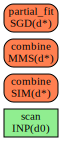

scan INP(d0)


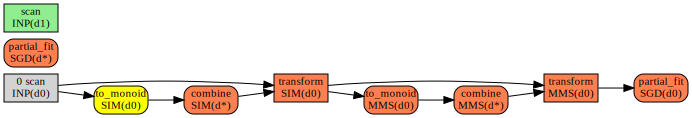

scan INP(d1)
spill /tmp/tmpdmqqwmvb/X_-1_d0_None.pkl /tmp/tmpdmqqwmvb/y_-1_d0_None.pkl


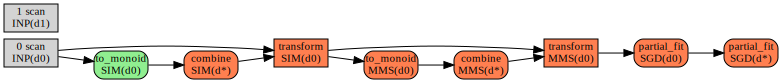

to_monoid SimpleImputer(d0)
load /tmp/tmpdmqqwmvb/X_-1_d0_None.pkl /tmp/tmpdmqqwmvb/y_-1_d0_None.pkl


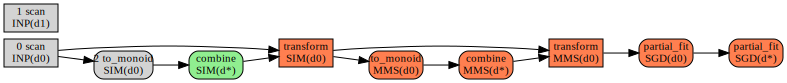

combine SimpleImputer(d*)


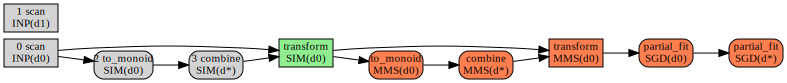

aborted spill of batch -1_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


transform SimpleImputer(d0)


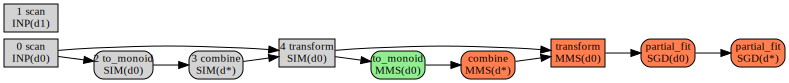

to_monoid MinMaxScaler(d0)


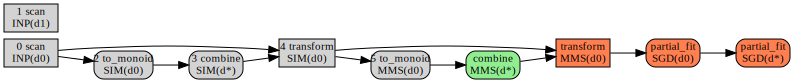

combine MinMaxScaler(d*)


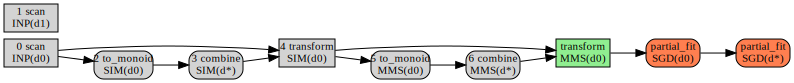

aborted spill of batch 0_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


transform MinMaxScaler(d0)


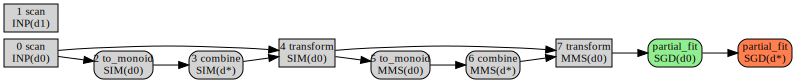

partial_fit SGDClassifier(d0)


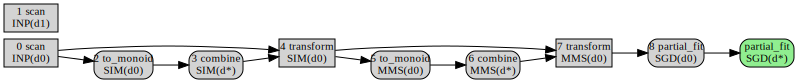

partial_fit SGDClassifier(d*)


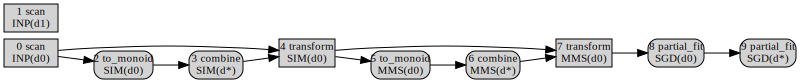

{
    "spill_count": 1,
    "load_count": 1,
    "spill_space": 53600,
    "load_space": 53600,
    "min_resident": 107200,
    "max_resident": 53600,
    "train_count": 6,
    "apply_count": 4,
    "metric_count": 0,
    "train_time": 0.1371166706085205,
    "apply_time": 0.15044379234313965,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 0.27068305015563965,
}
accuracy 63.333%


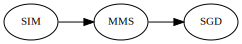

In [5]:
n_batches = 1
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
max_resident = 1 * math.ceil(train_data_space / n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=3, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")
trained.visualize()

### Example: batching using associativity where possible, non-incremental final estimator

spill /tmp/tmpax6or37x/X_-1_d1_None.pkl /tmp/tmpax6or37x/y_-1_d1_None.pkl
spill /tmp/tmpax6or37x/X_-1_d2_None.pkl /tmp/tmpax6or37x/y_-1_d2_None.pkl
load /tmp/tmpax6or37x/X_-1_d1_None.pkl /tmp/tmpax6or37x/y_-1_d1_None.pkl
load /tmp/tmpax6or37x/X_-1_d2_None.pkl /tmp/tmpax6or37x/y_-1_d2_None.pkl
spill /tmp/tmpax6or37x/X_-1_d2_None.pkl /tmp/tmpax6or37x/y_-1_d2_None.pkl
spill /tmp/tmpax6or37x/X_-1_d1_None.pkl /tmp/tmpax6or37x/y_-1_d1_None.pkl
load /tmp/tmpax6or37x/X_-1_d1_None.pkl /tmp/tmpax6or37x/y_-1_d1_None.pkl
spill /tmp/tmpax6or37x/X_0_d0_None.pkl /tmp/tmpax6or37x/y_0_d0_None.pkl
load /tmp/tmpax6or37x/X_-1_d2_None.pkl /tmp/tmpax6or37x/y_-1_d2_None.pkl
load /tmp/tmpax6or37x/X_0_d0_None.pkl /tmp/tmpax6or37x/y_0_d0_None.pkl
spill /tmp/tmpax6or37x/X_0_d2_None.pkl /tmp/tmpax6or37x/y_0_d2_None.pkl
spill /tmp/tmpax6or37x/X_0_d1_None.pkl /tmp/tmpax6or37x/y_0_d1_None.pkl
load /tmp/tmpax6or37x/X_0_d1_None.pkl /tmp/tmpax6or37x/y_0_d1_None.pkl
spill /tmp/tmpax6or37x/X_1_d0_None.pkl /tmp/tmpax6or37

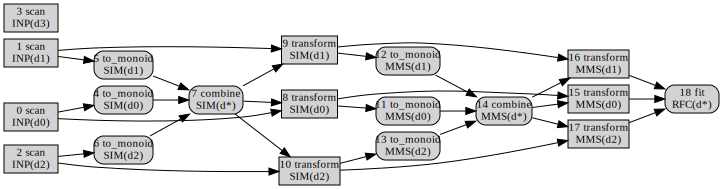

{
    "spill_count": 8,
    "load_count": 8,
    "spill_space": 142880,
    "load_space": 142880,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 9,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.5899167060852051,
    "apply_time": 0.265277624130249,
    "metric_time": 0,
    "critical_count": 8,
    "critical_time": 0.5753099918365479,
}
accuracy 70.303%


In [6]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline("rfc"), batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: pre-trained operator

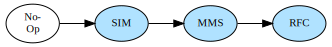

In [7]:
from lale.lib.lale import NoOp

pipeline = NoOp >> fresh_pipeline("rfc")
pipeline.visualize()

spill /tmp/tmpxmtowy54/X_-1_d1_None.pkl /tmp/tmpxmtowy54/y_-1_d1_None.pkl
spill /tmp/tmpxmtowy54/X_-1_d2_None.pkl /tmp/tmpxmtowy54/y_-1_d2_None.pkl
load /tmp/tmpxmtowy54/X_-1_d1_None.pkl /tmp/tmpxmtowy54/y_-1_d1_None.pkl
spill /tmp/tmpxmtowy54/X_0_d0_None.pkl /tmp/tmpxmtowy54/y_0_d0_None.pkl
load /tmp/tmpxmtowy54/X_-1_d2_None.pkl /tmp/tmpxmtowy54/y_-1_d2_None.pkl
load /tmp/tmpxmtowy54/X_0_d0_None.pkl /tmp/tmpxmtowy54/y_0_d0_None.pkl
spill /tmp/tmpxmtowy54/X_0_d2_None.pkl /tmp/tmpxmtowy54/y_0_d2_None.pkl
spill /tmp/tmpxmtowy54/X_0_d1_None.pkl /tmp/tmpxmtowy54/y_0_d1_None.pkl
load /tmp/tmpxmtowy54/X_0_d1_None.pkl /tmp/tmpxmtowy54/y_0_d1_None.pkl
spill /tmp/tmpxmtowy54/X_1_d0_None.pkl /tmp/tmpxmtowy54/y_1_d0_None.pkl
load /tmp/tmpxmtowy54/X_0_d2_None.pkl /tmp/tmpxmtowy54/y_0_d2_None.pkl
load /tmp/tmpxmtowy54/X_1_d0_None.pkl /tmp/tmpxmtowy54/y_1_d0_None.pkl
spill /tmp/tmpxmtowy54/X_1_d2_None.pkl /tmp/tmpxmtowy54/y_1_d2_None.pkl
spill /tmp/tmpxmtowy54/X_1_d1_None.pkl /tmp/tmpxmtowy54/y_1_d1

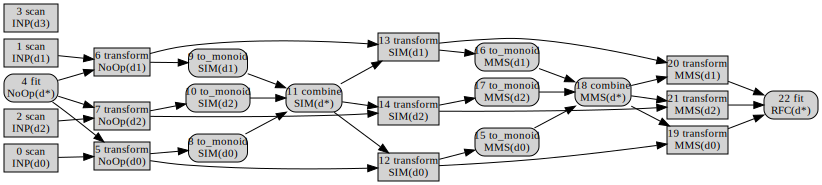

{
    "spill_count": 9,
    "load_count": 9,
    "spill_space": 160800,
    "load_space": 160800,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 10,
    "apply_count": 13,
    "metric_count": 0,
    "train_time": 0.5681195259094238,
    "apply_time": 0.3060336112976074,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 0.6415438652038574,
}
accuracy 70.303%


In [8]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(pipeline, batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: batching using associativity where possible, partial_fit otherwise
- unlike our batching patent, which always used partial_fit
- behavior still equivalent to sklearn
- potential advantages: less resident data; parallelism
- below are three runs with three different scheduling priorities

spill /tmp/tmpdf6b_po4/X_-1_d1_None.pkl /tmp/tmpdf6b_po4/y_-1_d1_None.pkl
spill /tmp/tmpdf6b_po4/X_-1_d2_None.pkl /tmp/tmpdf6b_po4/y_-1_d2_None.pkl
load /tmp/tmpdf6b_po4/X_-1_d1_None.pkl /tmp/tmpdf6b_po4/y_-1_d1_None.pkl
load /tmp/tmpdf6b_po4/X_-1_d2_None.pkl /tmp/tmpdf6b_po4/y_-1_d2_None.pkl
spill /tmp/tmpdf6b_po4/X_-1_d2_None.pkl /tmp/tmpdf6b_po4/y_-1_d2_None.pkl
spill /tmp/tmpdf6b_po4/X_-1_d1_None.pkl /tmp/tmpdf6b_po4/y_-1_d1_None.pkl
load /tmp/tmpdf6b_po4/X_-1_d1_None.pkl /tmp/tmpdf6b_po4/y_-1_d1_None.pkl
spill /tmp/tmpdf6b_po4/X_0_d0_None.pkl /tmp/tmpdf6b_po4/y_0_d0_None.pkl
load /tmp/tmpdf6b_po4/X_-1_d2_None.pkl /tmp/tmpdf6b_po4/y_-1_d2_None.pkl
load /tmp/tmpdf6b_po4/X_0_d0_None.pkl /tmp/tmpdf6b_po4/y_0_d0_None.pkl
spill /tmp/tmpdf6b_po4/X_0_d2_None.pkl /tmp/tmpdf6b_po4/y_0_d2_None.pkl
spill /tmp/tmpdf6b_po4/X_0_d1_None.pkl /tmp/tmpdf6b_po4/y_0_d1_None.pkl
load /tmp/tmpdf6b_po4/X_0_d1_None.pkl /tmp/tmpdf6b_po4/y_0_d1_None.pkl
spill /tmp/tmpdf6b_po4/X_1_d0_None.pkl /tmp/tmpdf6b_po

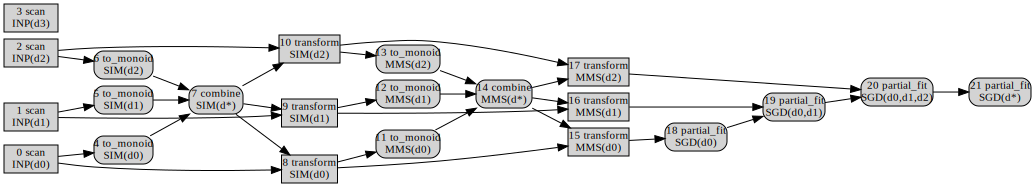

{
    "spill_count": 8,
    "load_count": 8,
    "spill_space": 142880,
    "load_space": 142880,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 12,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.1552271842956543,
    "apply_time": 0.24638652801513672,
    "metric_time": 0,
    "critical_count": 11,
    "critical_time": 0.18553829193115234,
}
accuracy 62.424%


In [9]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels, max_resident,
                           PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmpk5imkwm0/X_-1_d1_None.pkl /tmp/tmpk5imkwm0/y_-1_d1_None.pkl
spill /tmp/tmpk5imkwm0/X_-1_d2_None.pkl /tmp/tmpk5imkwm0/y_-1_d2_None.pkl
load /tmp/tmpk5imkwm0/X_-1_d1_None.pkl /tmp/tmpk5imkwm0/y_-1_d1_None.pkl
spill /tmp/tmpk5imkwm0/X_0_d0_None.pkl /tmp/tmpk5imkwm0/y_0_d0_None.pkl
load /tmp/tmpk5imkwm0/X_-1_d2_None.pkl /tmp/tmpk5imkwm0/y_-1_d2_None.pkl
load /tmp/tmpk5imkwm0/X_0_d0_None.pkl /tmp/tmpk5imkwm0/y_0_d0_None.pkl
spill /tmp/tmpk5imkwm0/X_0_d2_None.pkl /tmp/tmpk5imkwm0/y_0_d2_None.pkl
spill /tmp/tmpk5imkwm0/X_0_d1_None.pkl /tmp/tmpk5imkwm0/y_0_d1_None.pkl
load /tmp/tmpk5imkwm0/X_0_d1_None.pkl /tmp/tmpk5imkwm0/y_0_d1_None.pkl
load /tmp/tmpk5imkwm0/X_0_d2_None.pkl /tmp/tmpk5imkwm0/y_0_d2_None.pkl


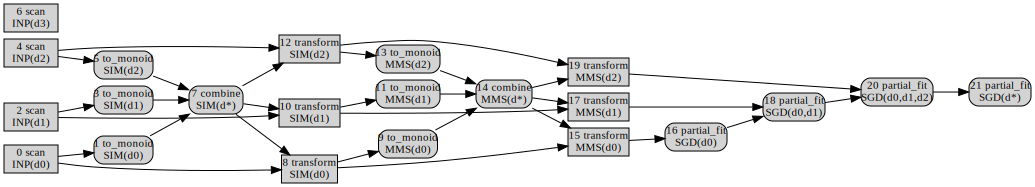

{
    "spill_count": 5,
    "load_count": 5,
    "spill_space": 89280,
    "load_space": 89280,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 12,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.14089584350585938,
    "apply_time": 0.3229641914367676,
    "metric_time": 0,
    "critical_count": 11,
    "critical_time": 0.2151048183441162,
}
accuracy 62.424%


In [10]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels, max_resident,
                           PrioBatch(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmpugo1dfo1/X_-1_d1_None.pkl /tmp/tmpugo1dfo1/y_-1_d1_None.pkl
spill /tmp/tmpugo1dfo1/X_-1_d2_None.pkl /tmp/tmpugo1dfo1/y_-1_d2_None.pkl
load /tmp/tmpugo1dfo1/X_-1_d1_None.pkl /tmp/tmpugo1dfo1/y_-1_d1_None.pkl
spill /tmp/tmpugo1dfo1/X_0_d0_None.pkl /tmp/tmpugo1dfo1/y_0_d0_None.pkl
load /tmp/tmpugo1dfo1/X_-1_d2_None.pkl /tmp/tmpugo1dfo1/y_-1_d2_None.pkl
load /tmp/tmpugo1dfo1/X_0_d0_None.pkl /tmp/tmpugo1dfo1/y_0_d0_None.pkl
spill /tmp/tmpugo1dfo1/X_1_d2_None.pkl /tmp/tmpugo1dfo1/y_1_d2_None.pkl
load /tmp/tmpugo1dfo1/X_1_d2_None.pkl /tmp/tmpugo1dfo1/y_1_d2_None.pkl


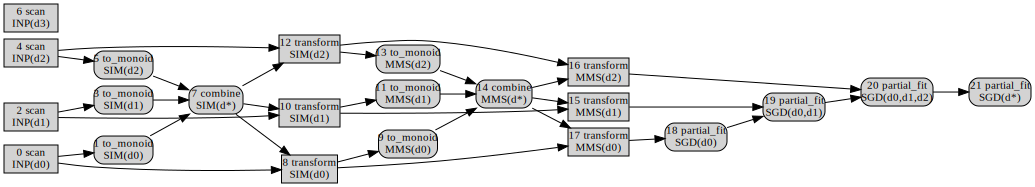

{
    "spill_count": 4,
    "load_count": 4,
    "spill_space": 71440,
    "load_space": 71440,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 12,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.273761510848999,
    "apply_time": 0.24356651306152344,
    "metric_time": 0,
    "critical_count": 11,
    "critical_time": 0.34171533584594727,
}
accuracy 62.424%


In [11]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels, max_resident,
                           PrioResourceAware(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: incremental computation, start using transformer before it has seen all data
- behavior not equivalent to sklearn, instead more similar to DL
- but may be "close enough" if operators are "convergent"
- advantage: need much less resident data
- amenable to early stopping, extracting a checkpoint

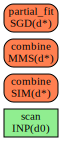

scan INP(d0)


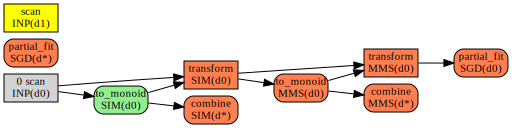

to_monoid SimpleImputer(d0)


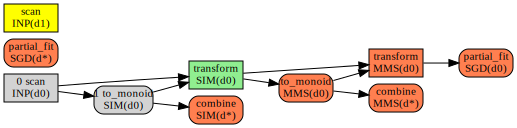

transform SimpleImputer(d0)


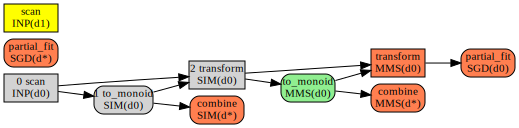

to_monoid MinMaxScaler(d0)


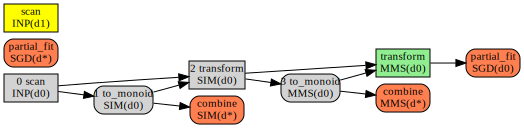

transform MinMaxScaler(d0)


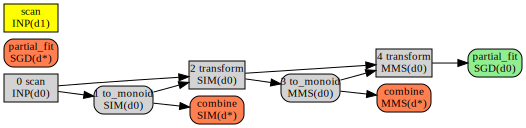

partial_fit SGDClassifier(d0)


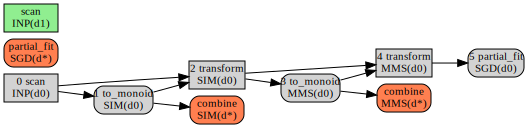

scan INP(d1)


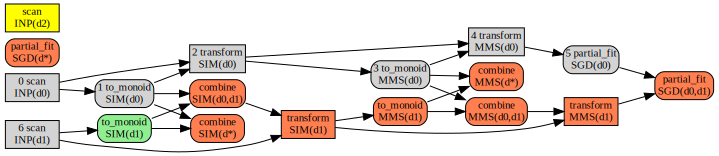

to_monoid SimpleImputer(d1)


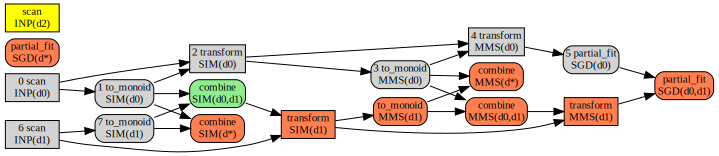

combine SimpleImputer(d0,d1)


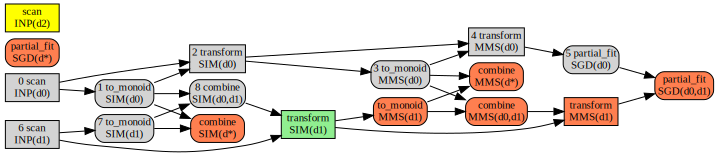

transform SimpleImputer(d1)


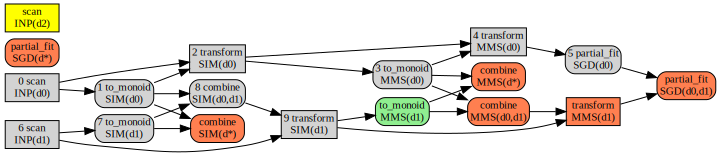

to_monoid MinMaxScaler(d1)


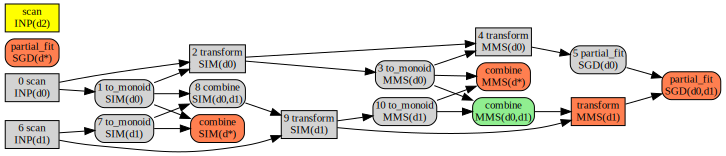

combine MinMaxScaler(d0,d1)


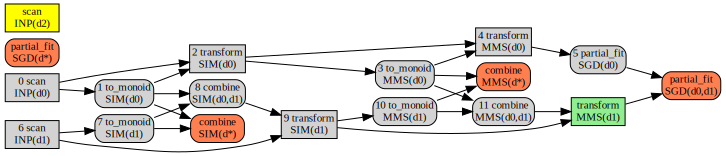

transform MinMaxScaler(d1)


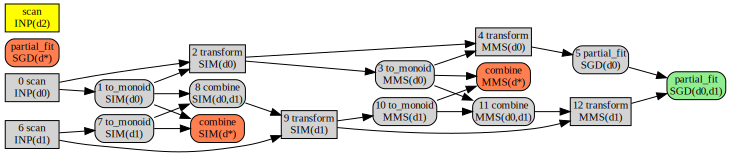

partial_fit SGDClassifier(d0,d1)


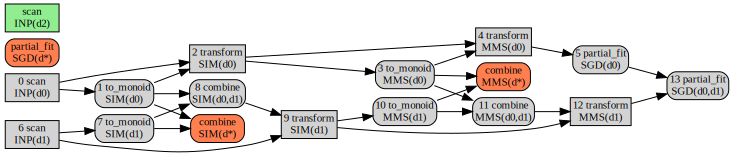

scan INP(d2)


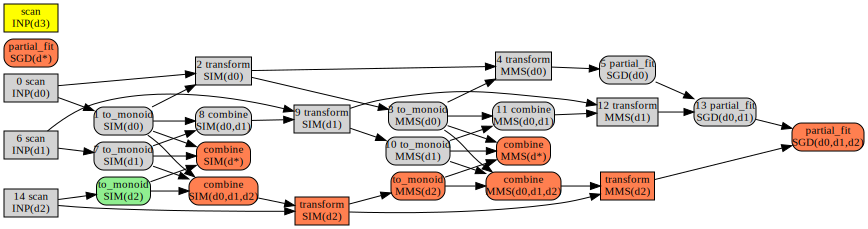

to_monoid SimpleImputer(d2)


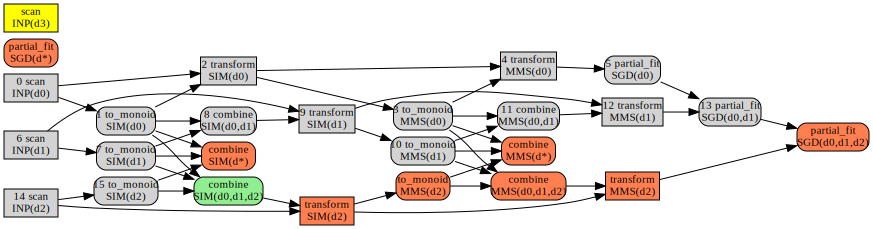

combine SimpleImputer(d0,d1,d2)


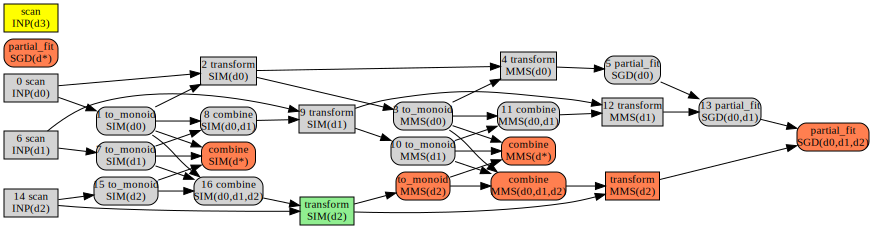

transform SimpleImputer(d2)


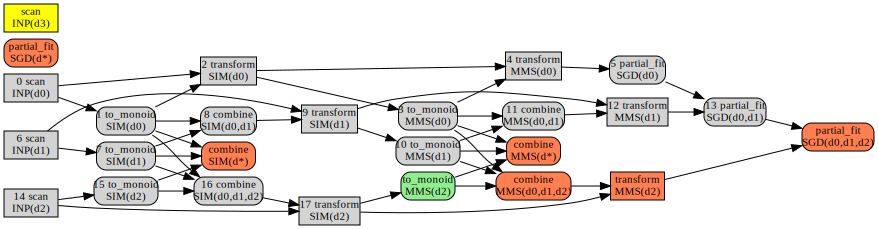

to_monoid MinMaxScaler(d2)


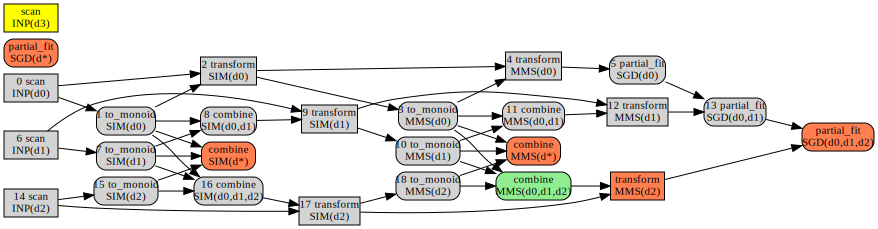

combine MinMaxScaler(d0,d1,d2)


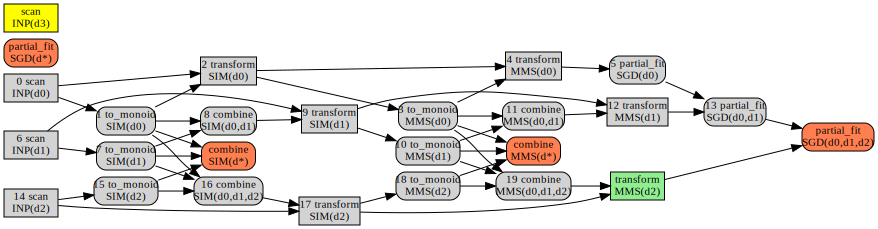

transform MinMaxScaler(d2)


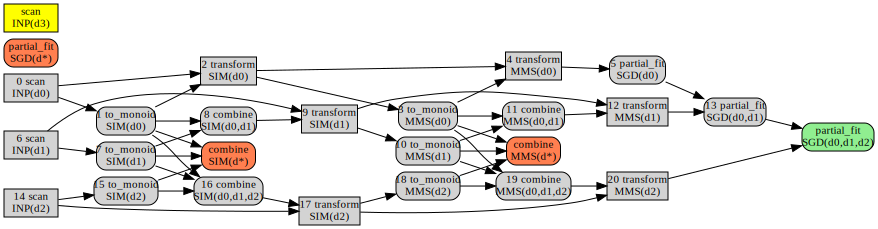

partial_fit SGDClassifier(d0,d1,d2)


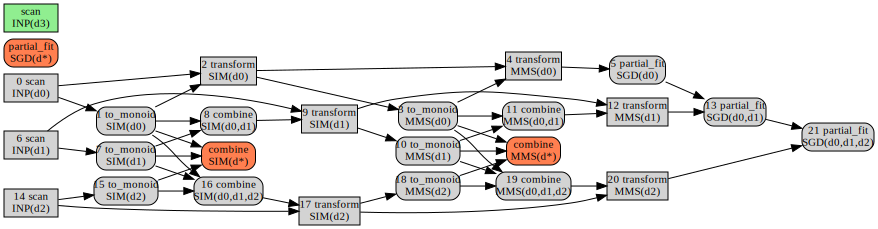

scan INP(d3)


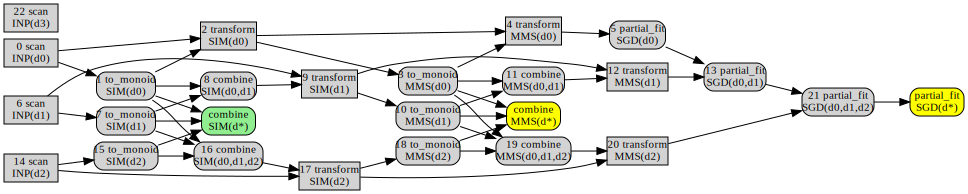

combine SimpleImputer(d*)


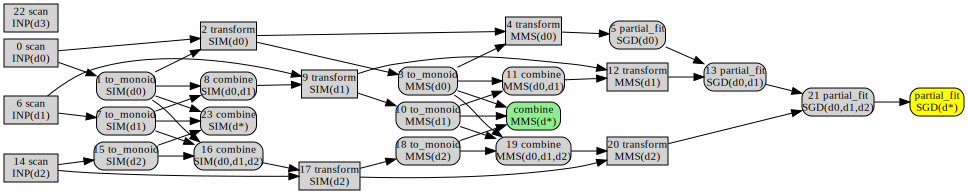

combine MinMaxScaler(d*)


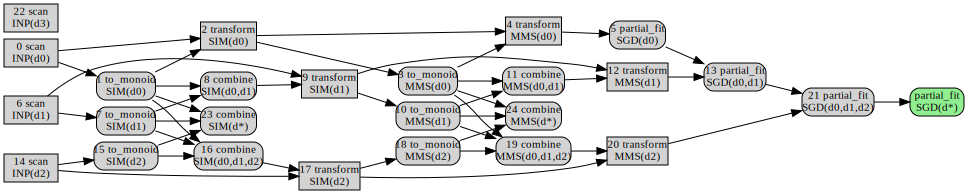

partial_fit SGDClassifier(d*)


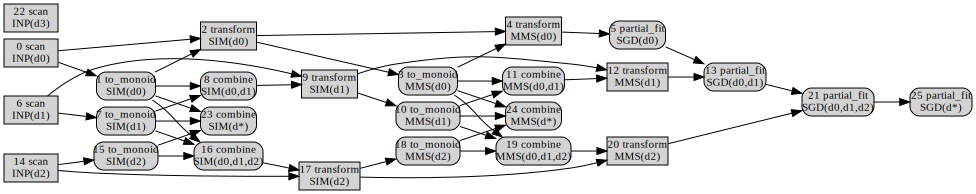

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 16,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.23849177360534668,
    "apply_time": 0.23823165893554688,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.2124922275543213,
}
accuracy 70.303%


In [12]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=3, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: learning curve during incremental fit_with_batches

spill /tmp/tmpwul9kmfh/X_-1_d0_None.pkl /tmp/tmpwul9kmfh/y_-1_d0_None.pkl
load /tmp/tmpwul9kmfh/X_-1_d0_None.pkl /tmp/tmpwul9kmfh/y_-1_d0_None.pkl
callback state 68.750%
callback state 68.750%, 69.955%
callback state 68.750%, 69.955%, 71.300%


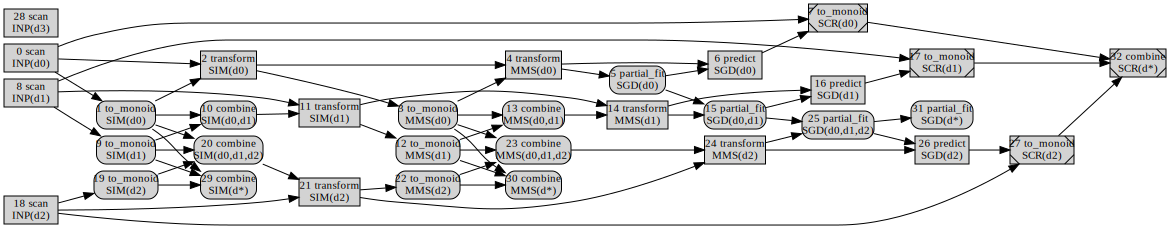

{
    "spill_count": 1,
    "load_count": 1,
    "spill_space": 17920,
    "load_space": 17920,
    "min_resident": 53760,
    "max_resident": 53601,
    "train_count": 16,
    "apply_count": 13,
    "metric_count": 4,
    "train_time": 0.11524152755737305,
    "apply_time": 0.1277918815612793,
    "metric_time": 0.035422325134277344,
    "critical_count": 12,
    "critical_time": 0.15506958961486816,
}
accuracy 70.303%


In [13]:
class DummyCallback:  # ideally, should create a dynamically updating plot in Jupyter
    def __init__(self):
        self.scores = []
    
    def __call__(self, score):
        self.scores.append(score)
        scores_s = ", ".join(f"{s:.3%}" for s in self.scores)
        print(f"callback state {scores_s}")

n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, accuracy_scorer, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=2, progress_callback=DummyCallback())
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: cross-validation without batching, using same-fold data for training
- behavior equivalent to sklearn
- reuse of lifted coefficients limited to first operator
- disambiguate some tasks by `#~f`, where f is the left-out fold
- using associativity where possible, partial_fit otherwise

spill /tmp/tmppz850m7r/X_-1_d0_None.pkl /tmp/tmppz850m7r/y_-1_d0_None.pkl
spill /tmp/tmppz850m7r/X_0_e0_f.pkl /tmp/tmppz850m7r/y_0_e0_f.pkl
spill /tmp/tmppz850m7r/X_-1_e0_None.pkl /tmp/tmppz850m7r/y_-1_e0_None.pkl
load /tmp/tmppz850m7r/X_-1_e0_None.pkl /tmp/tmppz850m7r/y_-1_e0_None.pkl
spill /tmp/tmppz850m7r/X_-1_f0_None.pkl /tmp/tmppz850m7r/y_-1_f0_None.pkl
spill /tmp/tmppz850m7r/X_0_f0_e.pkl /tmp/tmppz850m7r/y_0_f0_e.pkl
load /tmp/tmppz850m7r/X_-1_d0_None.pkl /tmp/tmppz850m7r/y_-1_d0_None.pkl
spill /tmp/tmppz850m7r/X_0_f0_f.pkl /tmp/tmppz850m7r/y_0_f0_f.pkl
spill /tmp/tmppz850m7r/X_-1_e0_None.pkl /tmp/tmppz850m7r/y_-1_e0_None.pkl
spill /tmp/tmppz850m7r/X_-1_d0_None.pkl /tmp/tmppz850m7r/y_-1_d0_None.pkl
load /tmp/tmppz850m7r/X_0_e0_f.pkl /tmp/tmppz850m7r/y_0_e0_f.pkl
spill /tmp/tmppz850m7r/X_1_e0_e.pkl /tmp/tmppz850m7r/y_1_e0_e.pkl
load /tmp/tmppz850m7r/X_0_f0_e.pkl /tmp/tmppz850m7r/y_0_f0_e.pkl
load /tmp/tmppz850m7r/X_1_e0_e.pkl /tmp/tmppz850m7r/y_1_e0_e.pkl
load /tmp/tmppz850m7r/X_-

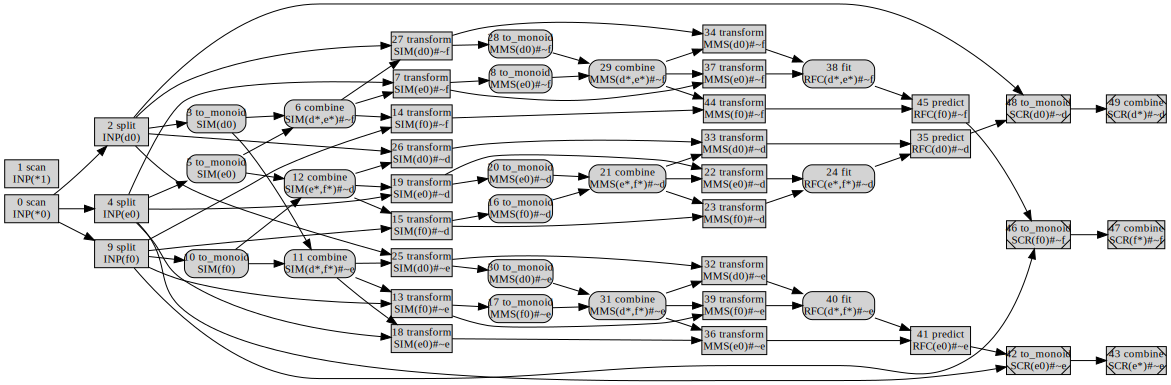

{
    "spill_count": 9,
    "load_count": 9,
    "spill_space": 160720,
    "load_space": 160720,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 18,
    "apply_count": 26,
    "metric_count": 6,
    "train_time": 1.011890172958374,
    "apply_time": 0.5737299919128418,
    "metric_time": 0.05094099044799805,
    "critical_count": 12,
    "critical_time": 0.599461555480957,
}
accuracies 72.768%, 68.161%, 69.507%


In [14]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("rfc"), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with batching, using same-fold data for training
- compared to cross-validation without batching, requires less resident memory

spill /tmp/tmpvo4_f68s/X_-1_*1_None.pkl /tmp/tmpvo4_f68s/y_-1_*1_None.pkl
spill /tmp/tmpvo4_f68s/X_-1_d0_None.pkl /tmp/tmpvo4_f68s/y_-1_d0_None.pkl
spill /tmp/tmpvo4_f68s/X_-1_e0_None.pkl /tmp/tmpvo4_f68s/y_-1_e0_None.pkl
load /tmp/tmpvo4_f68s/X_-1_*1_None.pkl /tmp/tmpvo4_f68s/y_-1_*1_None.pkl
spill /tmp/tmpvo4_f68s/X_-1_f0_None.pkl /tmp/tmpvo4_f68s/y_-1_f0_None.pkl
spill /tmp/tmpvo4_f68s/X_-1_d1_None.pkl /tmp/tmpvo4_f68s/y_-1_d1_None.pkl
spill /tmp/tmpvo4_f68s/X_0_e1_f.pkl /tmp/tmpvo4_f68s/y_0_e1_f.pkl
spill /tmp/tmpvo4_f68s/X_-1_e1_None.pkl /tmp/tmpvo4_f68s/y_-1_e1_None.pkl
load /tmp/tmpvo4_f68s/X_-1_f0_None.pkl /tmp/tmpvo4_f68s/y_-1_f0_None.pkl
spill /tmp/tmpvo4_f68s/X_-1_f1_None.pkl /tmp/tmpvo4_f68s/y_-1_f1_None.pkl
spill /tmp/tmpvo4_f68s/X_0_f1_f.pkl /tmp/tmpvo4_f68s/y_0_f1_f.pkl
spill /tmp/tmpvo4_f68s/X_0_f1_e.pkl /tmp/tmpvo4_f68s/y_0_f1_e.pkl
load /tmp/tmpvo4_f68s/X_-1_d0_None.pkl /tmp/tmpvo4_f68s/y_-1_d0_None.pkl
spill /tmp/tmpvo4_f68s/X_0_f1_d.pkl /tmp/tmpvo4_f68s/y_0_f1_d.pkl

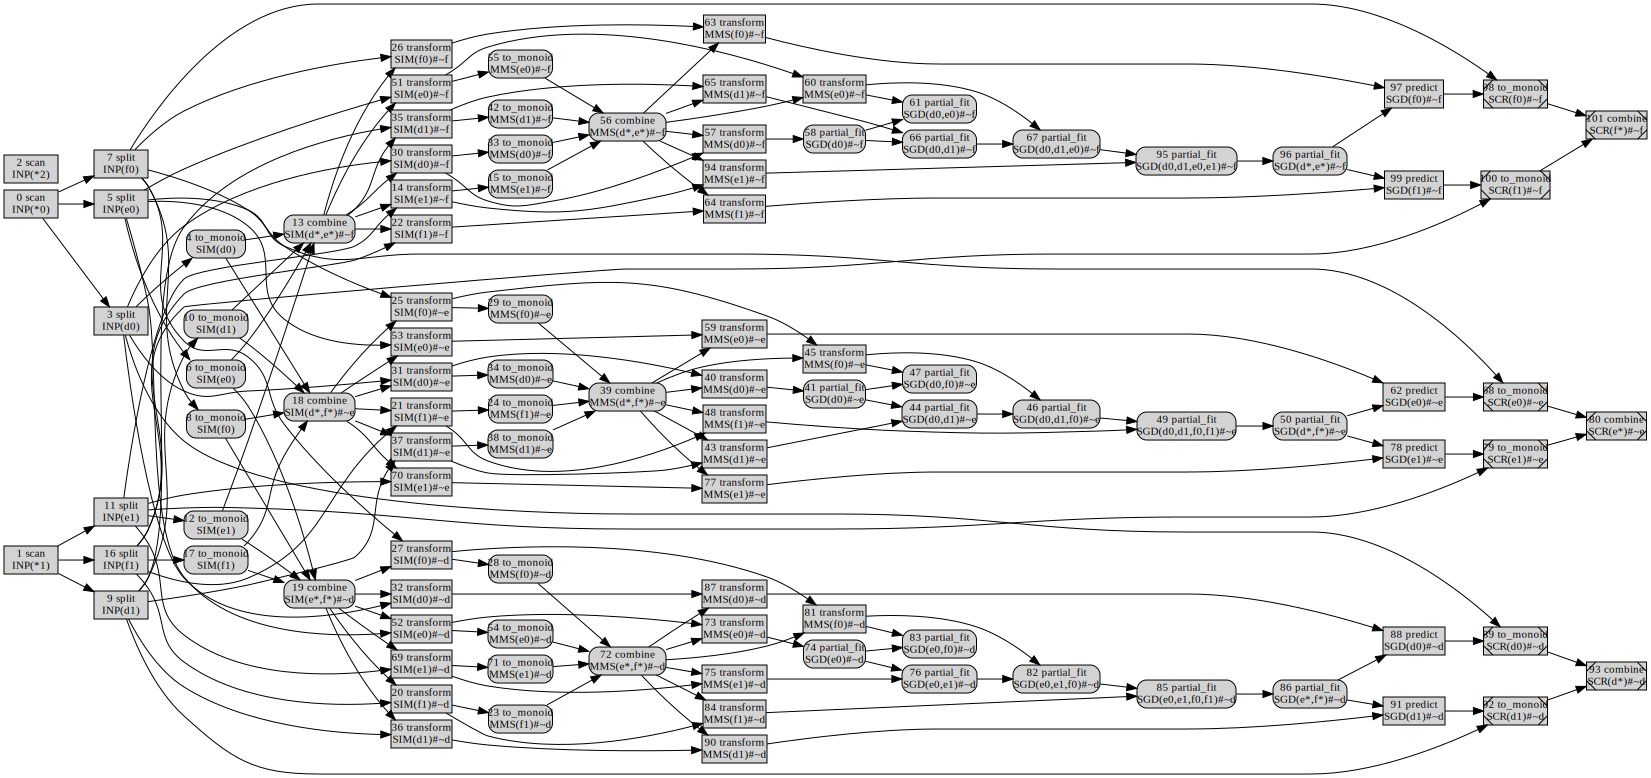

{
    "spill_count": 22,
    "load_count": 22,
    "spill_space": 214160,
    "load_space": 214160,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 42,
    "apply_count": 51,
    "metric_count": 9,
    "train_time": 0.37338733673095703,
    "apply_time": 1.107926845550537,
    "metric_time": 0.12203240394592285,
    "critical_count": 16,
    "critical_time": 0.28290653228759766,
}
accuracies 68.304%, 73.661%, 62.162%


In [15]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with out-of-fold samples
- not sklearn compatible
- might generalize better by following best practices for stacking ensembles
- depends on transformers being convergent
- fewer tasks overall than for cross-validation with in-fold samples

spill /tmp/tmpzlzz8jbt/X_-1_d0_None.pkl /tmp/tmpzlzz8jbt/y_-1_d0_None.pkl
spill /tmp/tmpzlzz8jbt/X_-1_e0_None.pkl /tmp/tmpzlzz8jbt/y_-1_e0_None.pkl
load /tmp/tmpzlzz8jbt/X_-1_e0_None.pkl /tmp/tmpzlzz8jbt/y_-1_e0_None.pkl
load /tmp/tmpzlzz8jbt/X_-1_d0_None.pkl /tmp/tmpzlzz8jbt/y_-1_d0_None.pkl
spill /tmp/tmpzlzz8jbt/X_-1_f0_None.pkl /tmp/tmpzlzz8jbt/y_-1_f0_None.pkl
spill /tmp/tmpzlzz8jbt/X_-1_e0_None.pkl /tmp/tmpzlzz8jbt/y_-1_e0_None.pkl
load /tmp/tmpzlzz8jbt/X_-1_e0_None.pkl /tmp/tmpzlzz8jbt/y_-1_e0_None.pkl
load /tmp/tmpzlzz8jbt/X_-1_f0_None.pkl /tmp/tmpzlzz8jbt/y_-1_f0_None.pkl


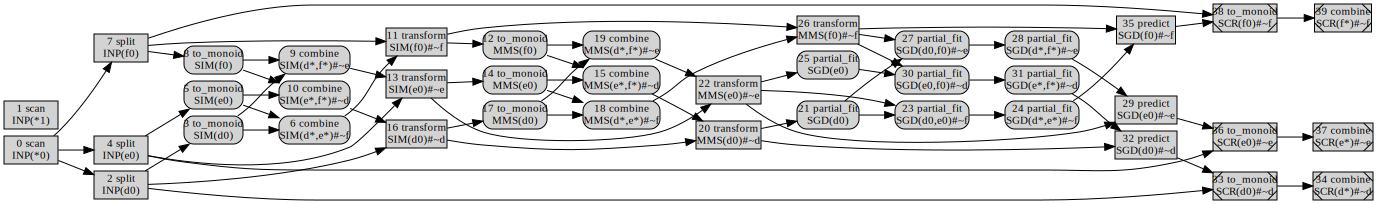

{
    "spill_count": 4,
    "load_count": 4,
    "spill_space": 71440,
    "load_space": 71440,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 20,
    "apply_count": 14,
    "metric_count": 6,
    "train_time": 0.1475081443786621,
    "apply_time": 0.19675946235656738,
    "metric_time": 0.04687142372131348,
    "critical_count": 14,
    "critical_time": 0.18758249282836914,
}
accuracies 69.196%, 68.610%, 71.749%


In [16]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

spill /tmp/tmpuwspfoxy/X_-1_*1_None.pkl /tmp/tmpuwspfoxy/y_-1_*1_None.pkl
spill /tmp/tmpuwspfoxy/X_-1_d0_None.pkl /tmp/tmpuwspfoxy/y_-1_d0_None.pkl
spill /tmp/tmpuwspfoxy/X_-1_e0_None.pkl /tmp/tmpuwspfoxy/y_-1_e0_None.pkl
load /tmp/tmpuwspfoxy/X_-1_*1_None.pkl /tmp/tmpuwspfoxy/y_-1_*1_None.pkl
spill /tmp/tmpuwspfoxy/X_-1_f0_None.pkl /tmp/tmpuwspfoxy/y_-1_f0_None.pkl
spill /tmp/tmpuwspfoxy/X_-1_d1_None.pkl /tmp/tmpuwspfoxy/y_-1_d1_None.pkl
spill /tmp/tmpuwspfoxy/X_-1_e1_None.pkl /tmp/tmpuwspfoxy/y_-1_e1_None.pkl
load /tmp/tmpuwspfoxy/X_-1_f0_None.pkl /tmp/tmpuwspfoxy/y_-1_f0_None.pkl
load /tmp/tmpuwspfoxy/X_-1_d0_None.pkl /tmp/tmpuwspfoxy/y_-1_d0_None.pkl
spill /tmp/tmpuwspfoxy/X_-1_f1_None.pkl /tmp/tmpuwspfoxy/y_-1_f1_None.pkl
load /tmp/tmpuwspfoxy/X_-1_d1_None.pkl /tmp/tmpuwspfoxy/y_-1_d1_None.pkl
spill /tmp/tmpuwspfoxy/X_0_f1_f.pkl /tmp/tmpuwspfoxy/y_0_f1_f.pkl
spill /tmp/tmpuwspfoxy/X_-1_f0_None.pkl /tmp/tmpuwspfoxy/y_-1_f0_None.pkl
spill /tmp/tmpuwspfoxy/X_0_f0_f.pkl /tmp/tmpuwspfo

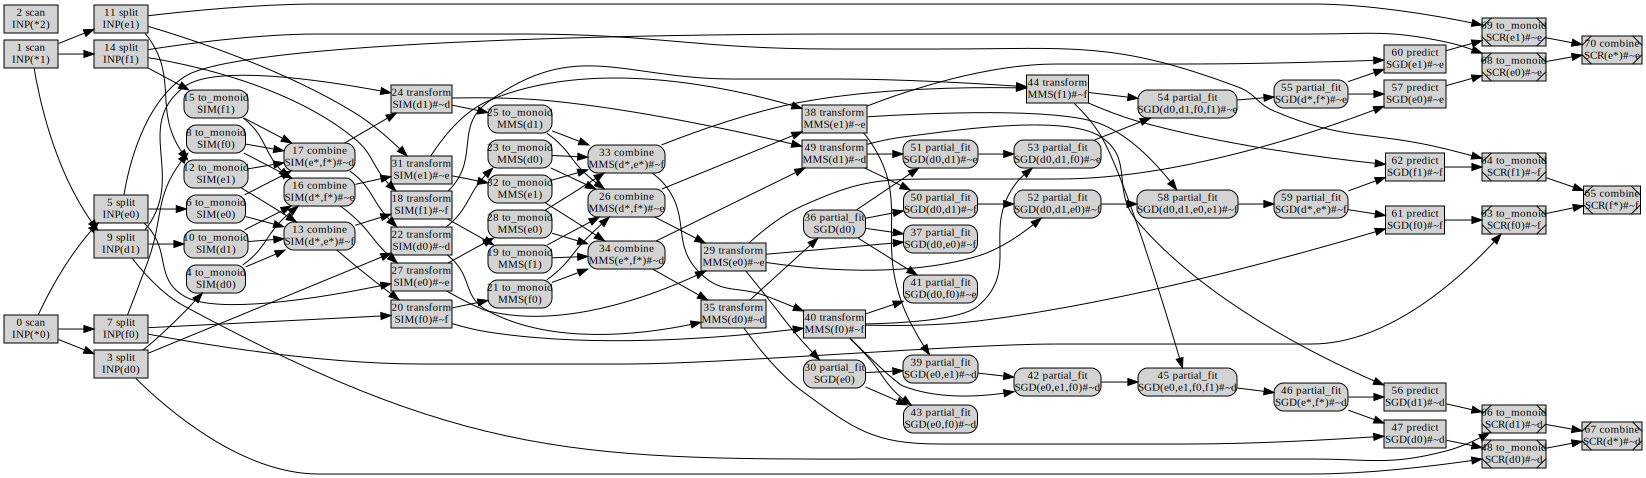

{
    "spill_count": 15,
    "load_count": 15,
    "spill_space": 151840,
    "load_space": 151840,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 35,
    "apply_count": 27,
    "metric_count": 9,
    "train_time": 0.42530226707458496,
    "apply_time": 0.5540223121643066,
    "metric_time": 0.0675513744354248,
    "critical_count": 16,
    "critical_time": 0.24411582946777344,
}
accuracies 68.304%, 72.321%, 66.667%


In [17]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))